In [1]:
pip install mysql-connector-python --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import mysql.connector as sql
from sqlalchemy import create_engine
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
data_path = 'FMCG_data.csv'
fmcg_data = pd.read_csv(data_path)

In [4]:
# Checking for missing values in the dataset
missing_values = fmcg_data.isnull().sum()
missing_values_percentage = (fmcg_data.isnull().sum() / len(fmcg_data) * 100)

missing_values_df = pd.DataFrame({"Missing Values": missing_values,"Missing Values in Percentage (%)": missing_values_percentage})
missing_values_df = missing_values_df[missing_values_df["Missing Values"] > 0]
print(missing_values_df)

                              Missing Values  Missing Values in Percentage (%)
workers_num                              990                             3.960
wh_est_year                            11881                            47.524
approved_wh_govt_certificate             908                             3.632


In [5]:
# The missing percentage is too high for wh_est_year (47% is close to 50%, meaning it may introduce bias) 
fmcg_data.drop('wh_est_year',axis=1,inplace=True)

In [6]:
# Detecting binary columns and converting them to 'category' dtype

for column in fmcg_data.columns:
    if fmcg_data[column].nunique() == 2:  # Checking if the column has exactly two unique values
        fmcg_data[column] = fmcg_data[column].astype('category')

# Now describe the data separately for categorical and numerical data
categorical_cols = fmcg_data.select_dtypes(include=['object', 'category']).columns
numeric_cols = fmcg_data.select_dtypes(include=['float64', 'int64']).columns

# Descriptive statistics for categorical and numeric columns
categorical_stats = fmcg_data[categorical_cols].describe()
numeric_stats = fmcg_data[numeric_cols].describe()


# Display the results 

print("________________________________________________________________________________")
print("\nNumeric Column Stats:")
display(numeric_stats.style.format("{:.2f}"))
print("________________________________________________________________________________")

print("\nCategorical Column Stats:")
display(categorical_stats)
print("________________________________________________________________________________")

________________________________________________________________________________

Numeric Column Stats:


,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,dist_from_hub,workers_num,storage_issue_reported_l3m,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
count,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,24010.00,25000.00,25000.00,25000.00,25000.00
mean,4.09,0.77,3.10,4985.71,42.42,163.54,28.94,17.13,3.48,18.81,22102.63
std,2.61,1.20,1.14,1052.83,16.06,62.72,7.87,9.16,1.69,8.63,11607.76
min,0.00,0.00,0.00,1821.00,15.00,55.00,10.00,0.00,0.00,1.00,2065.00
25%,2.00,0.00,2.00,4313.00,29.00,109.00,24.00,10.00,2.00,11.00,13059.00
50%,4.00,0.00,3.00,4859.00,42.00,164.00,28.00,18.00,3.00,21.00,22101.00
75%,6.00,1.00,4.00,5500.00,56.00,218.00,33.00,24.00,5.00,26.00,30103.00
max,8.00,5.00,12.00,11008.00,70.00,271.00,98.00,39.00,6.00,32.00,55151.00


________________________________________________________________________________

Categorical Column Stats:


,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,wh_owner_type,flood_impacted,flood_proof,electric_supply,temp_reg_mach,approved_wh_govt_certificate
count,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,24092
unique,25000,25000,2,3,4,6,2,2,2,2,2,5
top,WH_100000,EID_50000,Rural,Large,North,Zone 6,Company Owned,0,0,1,0,C
freq,1,1,22957,10169,10278,8339,13578,22546,23634,16422,17418,5501


________________________________________________________________________________


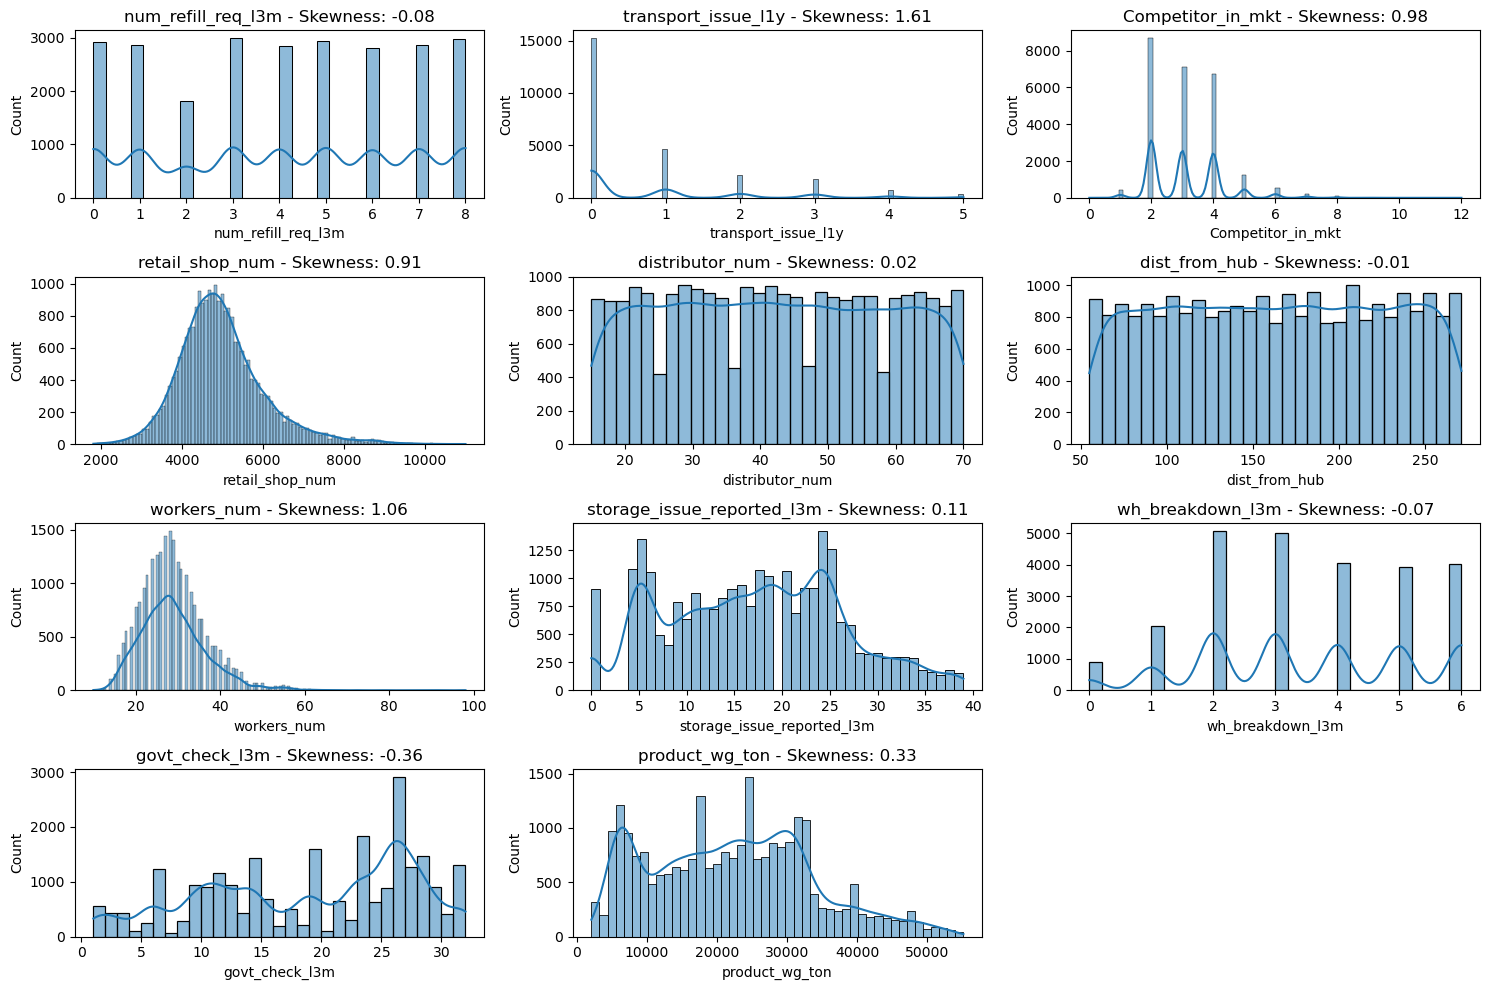

Skewness of Numeric Columns:
 num_refill_req_l3m           -0.075217
transport_issue_l1y           1.610907
Competitor_in_mkt             0.978456
retail_shop_num               0.908302
distributor_num               0.015213
dist_from_hub                -0.005999
workers_num                   1.059911
storage_issue_reported_l3m    0.113345
wh_breakdown_l3m             -0.068026
govt_check_l3m               -0.363262
product_wg_ton                0.331631
dtype: float64


In [7]:
#visualize skewness
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i + 1)  # Adjusting subplot grid based on number of numeric columns
    sns.histplot(fmcg_data[col], kde=True)
    plt.title(f'{col} - Skewness: {fmcg_data[col].skew():.2f}')
    plt.tight_layout()

plt.show()

# calculating the skewness values for each numeric column
skewness = fmcg_data[numeric_cols].skew()
print("Skewness of Numeric Columns:\n", skewness)

In [8]:
# missing_value treatment
def handle_missing_values(df):
    
    for col in numeric_cols:
        if df[col].skew() > 0.5 or df[col].skew() < -0.5: 
             # Highly skewed
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    
    for col in categorical_cols:
        # Filling missing values with the most frequent value (mode)
        df[col].fillna(df[col].mode()[0], inplace=True)

# Applying the function to handle missing values
handle_missing_values(fmcg_data)

# Display summary to verify changes
print(fmcg_data.isnull().sum())

Ware_house_ID                   0
WH_Manager_ID                   0
Location_type                   0
WH_capacity_size                0
zone                            0
WH_regional_zone                0
num_refill_req_l3m              0
transport_issue_l1y             0
Competitor_in_mkt               0
retail_shop_num                 0
wh_owner_type                   0
distributor_num                 0
flood_impacted                  0
flood_proof                     0
electric_supply                 0
dist_from_hub                   0
workers_num                     0
storage_issue_reported_l3m      0
temp_reg_mach                   0
approved_wh_govt_certificate    0
wh_breakdown_l3m                0
govt_check_l3m                  0
product_wg_ton                  0
dtype: int64


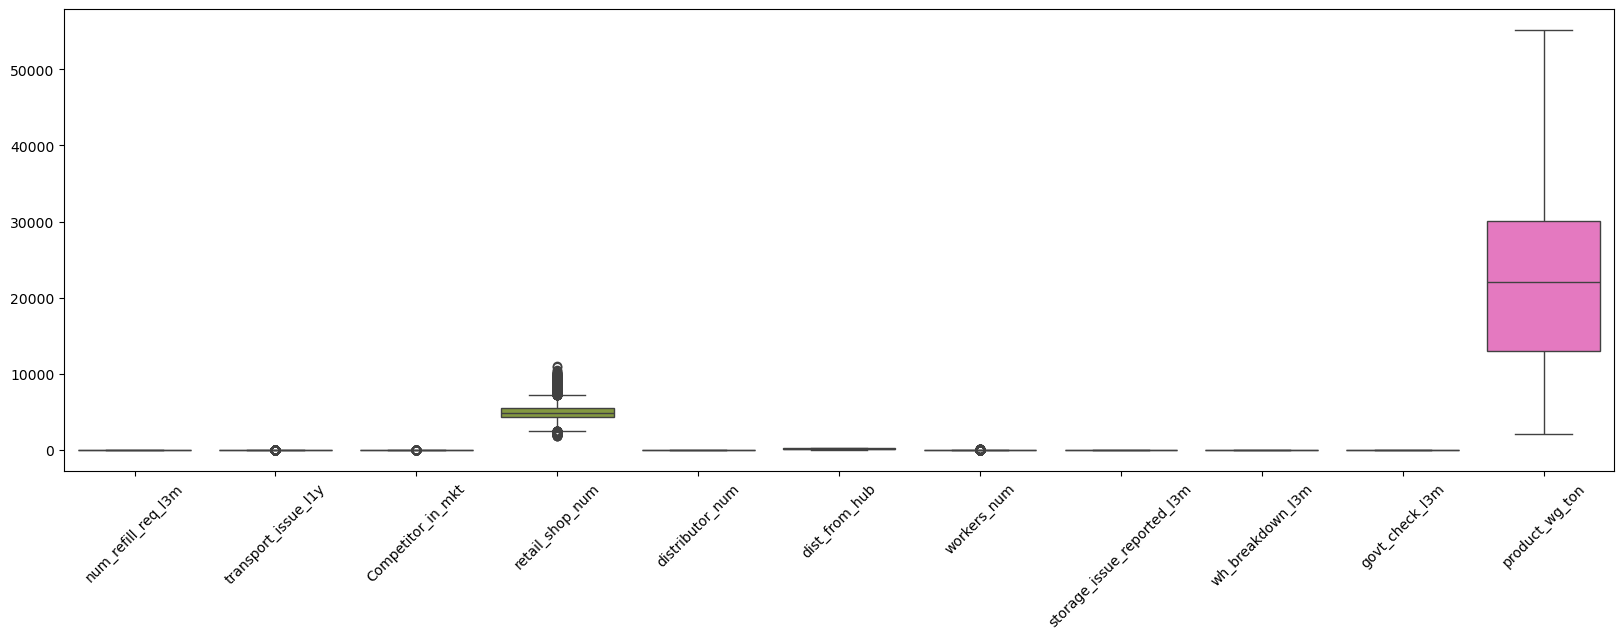

In [9]:
#before outlayer treatment
sns.boxplot(data= fmcg_data)
plt.gcf().set_size_inches(20,6) 
plt.xticks(rotation= 45)
plt.show()

In [10]:
# Outlier Treatment - Winsorization using IQR
column = 'retail_shop_num' 

q1 = fmcg_data[column].quantile(0.25)
q3 = fmcg_data[column].quantile(0.75)
iqr = q3 - q1
lf = q1 - 1.5 * iqr  # Lower fence
uf = q3 + 1.5 * iqr  # Upper fence
fmcg_data.loc[fmcg_data[column] < lf, column] = lf
fmcg_data.loc[fmcg_data[column] > uf, column] = uf

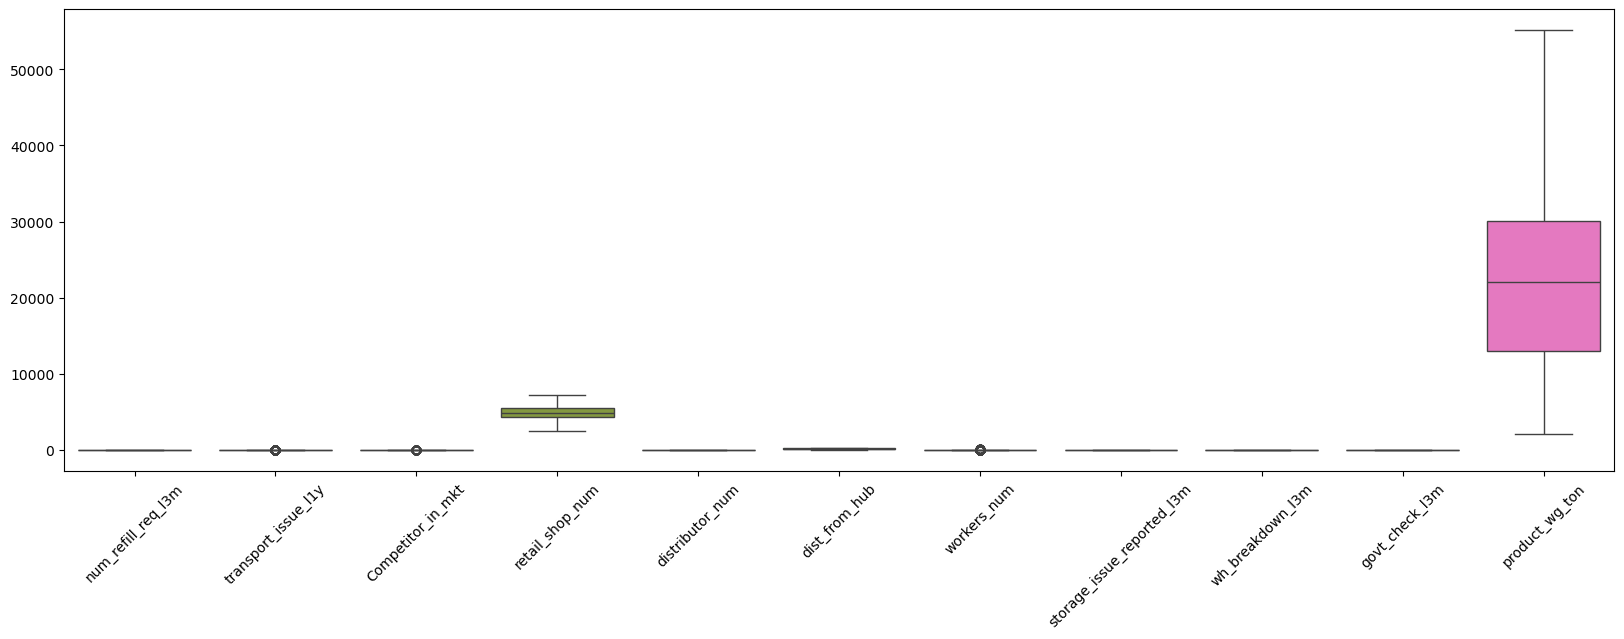

In [11]:
#after outlayer treatment
sns.boxplot(data= fmcg_data)
plt.gcf().set_size_inches(20,6) 
plt.xticks(rotation= 45)
plt.show()

In [12]:
# cleaned Data exported

#fmcg_data.to_csv("cleaned_fmcg_data.csv", index=False)  # index=False to not include row indices in the file
#print("Data exported successfully to:")

DAY2:

In [14]:
cat=['Location_type', 'WH_capacity_size','zone', 'WH_regional_zone', 'wh_owner_type', 'flood_impacted','flood_proof', 'electric_supply', 'temp_reg_mach','approved_wh_govt_certificate']

In [15]:
for col in cat:
    print(f'Name of the Column:{col}\n')
    print("Total no of unique values in", col, "are", fmcg_data[col].nunique())
    print("Unique values in", col, "are", fmcg_data[col].unique())
    print("Mode for", col, "is", fmcg_data[col].mode()[0])
    print("Count of categories is", fmcg_data[col].value_counts())
    print("-------------------------------------------------------------")

Name of the Column:Location_type

Total no of unique values in Location_type are 2
Unique values in Location_type are ['Urban', 'Rural']
Categories (2, object): ['Rural', 'Urban']
Mode for Location_type is Rural
Count of categories is Location_type
Rural    22957
Urban     2043
Name: count, dtype: int64
-------------------------------------------------------------
Name of the Column:WH_capacity_size

Total no of unique values in WH_capacity_size are 3
Unique values in WH_capacity_size are ['Small' 'Large' 'Mid']
Mode for WH_capacity_size is Large
Count of categories is WH_capacity_size
Large    10169
Mid      10020
Small     4811
Name: count, dtype: int64
-------------------------------------------------------------
Name of the Column:zone

Total no of unique values in zone are 4
Unique values in zone are ['West' 'North' 'South' 'East']
Mode for zone is North
Count of categories is zone
North    10278
West      7931
South     6362
East       429
Name: count, dtype: int64
--------------

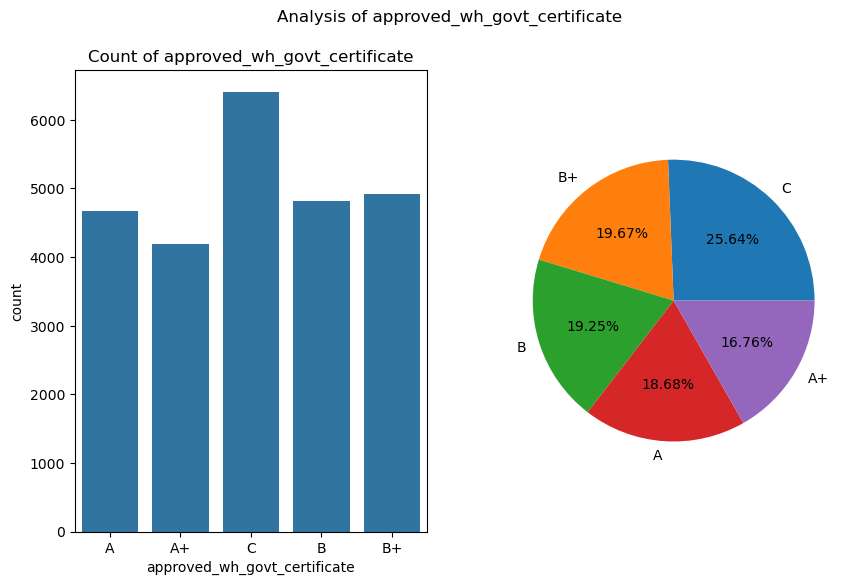

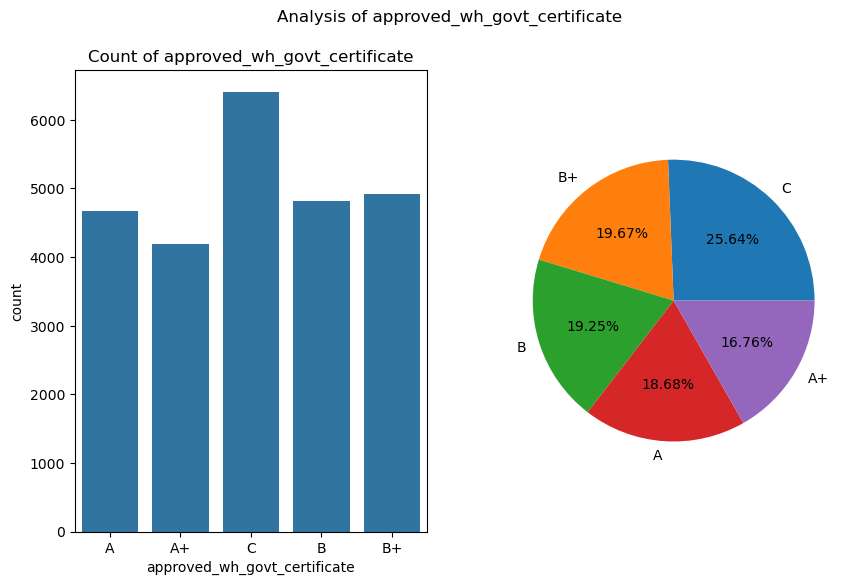

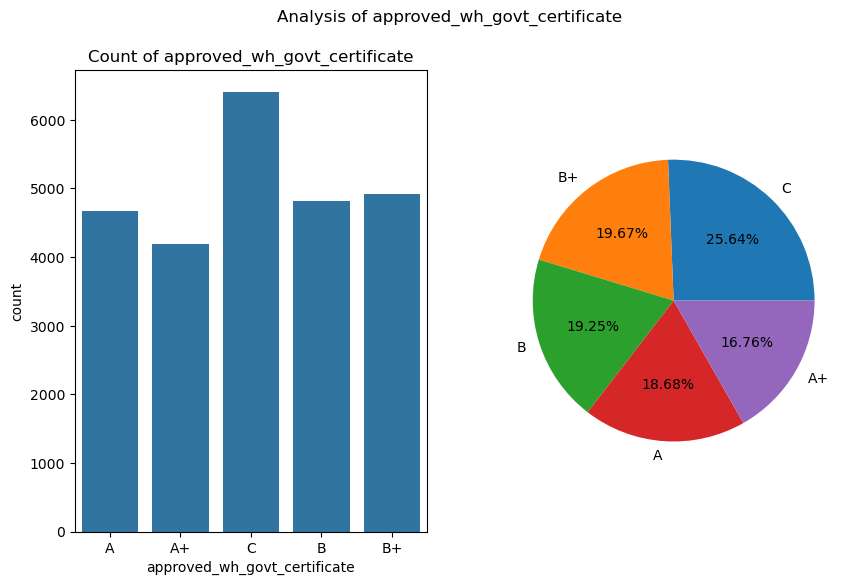

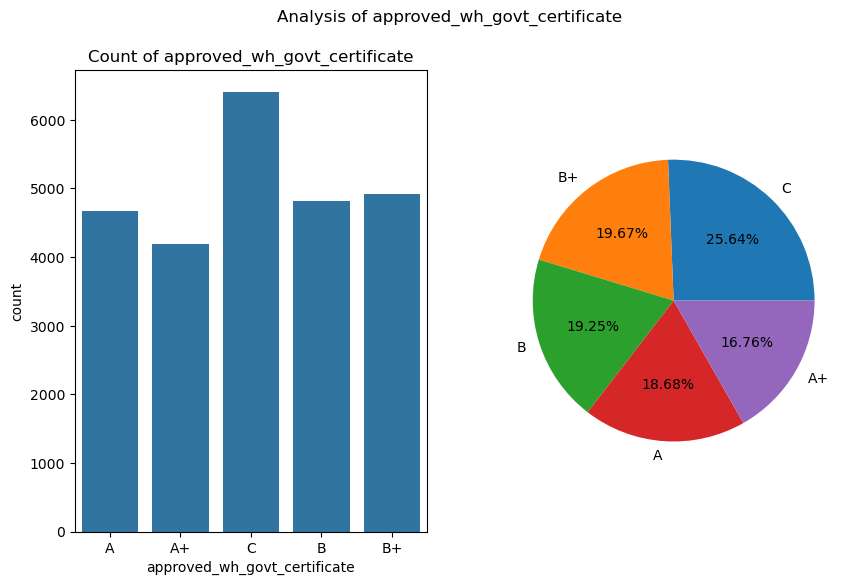

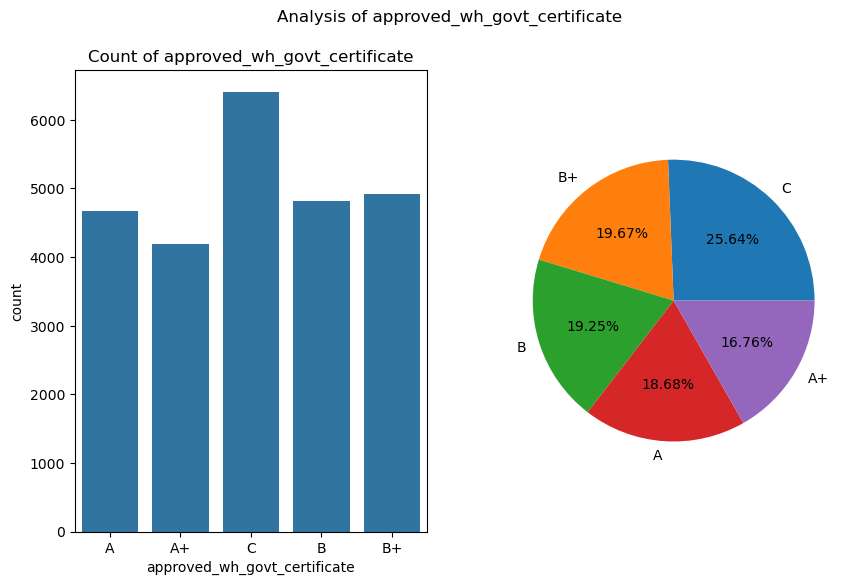

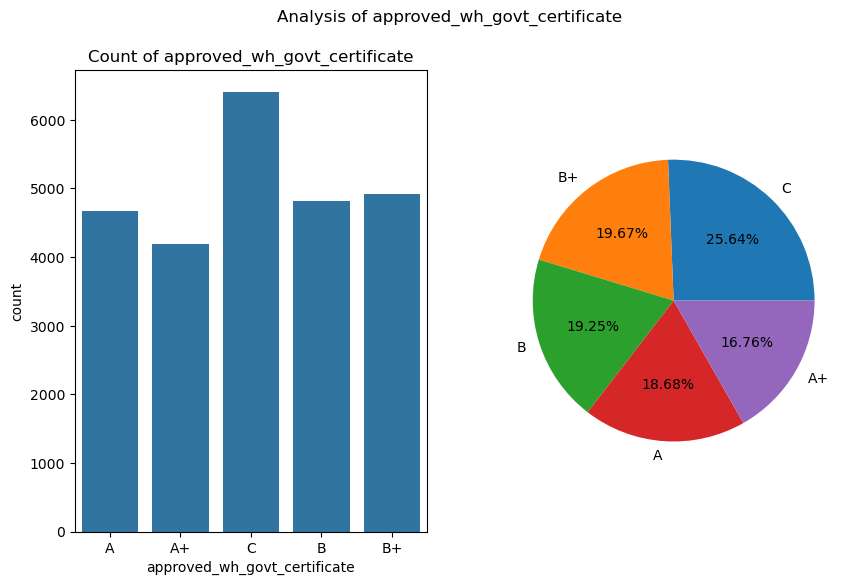

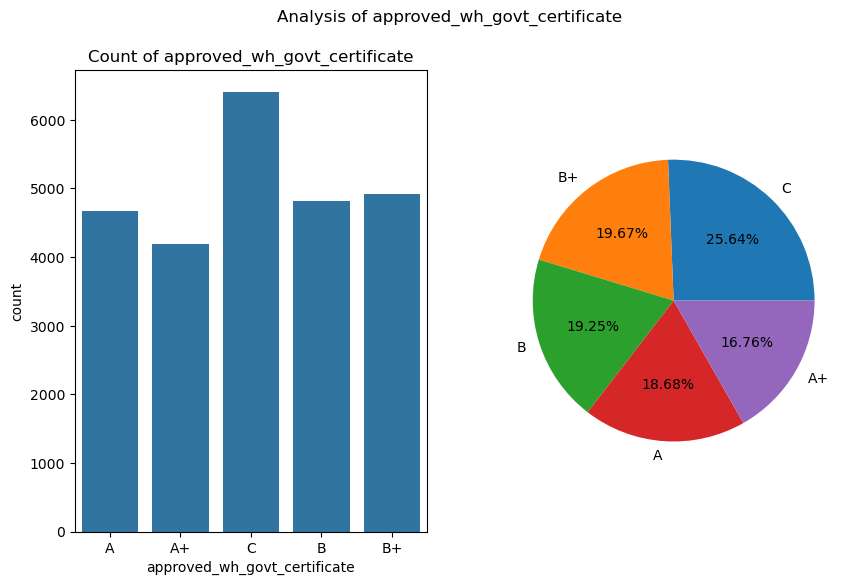

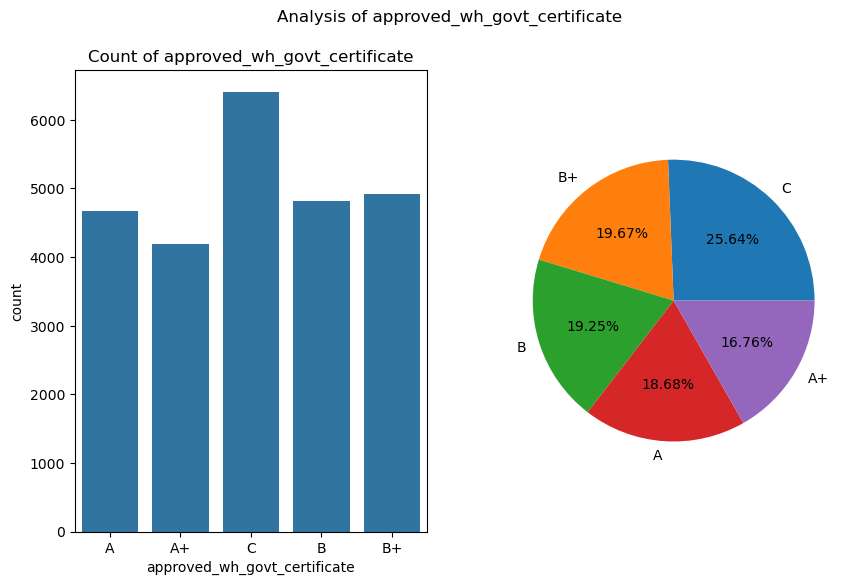

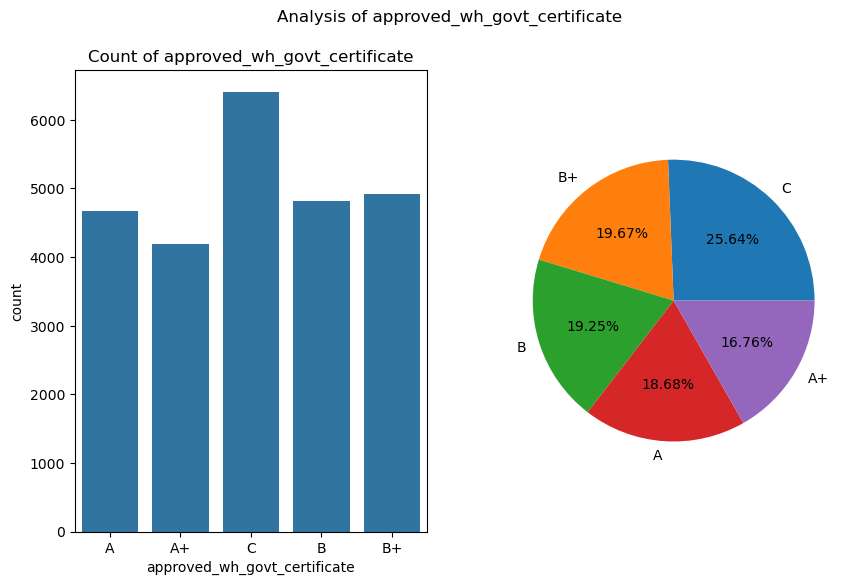

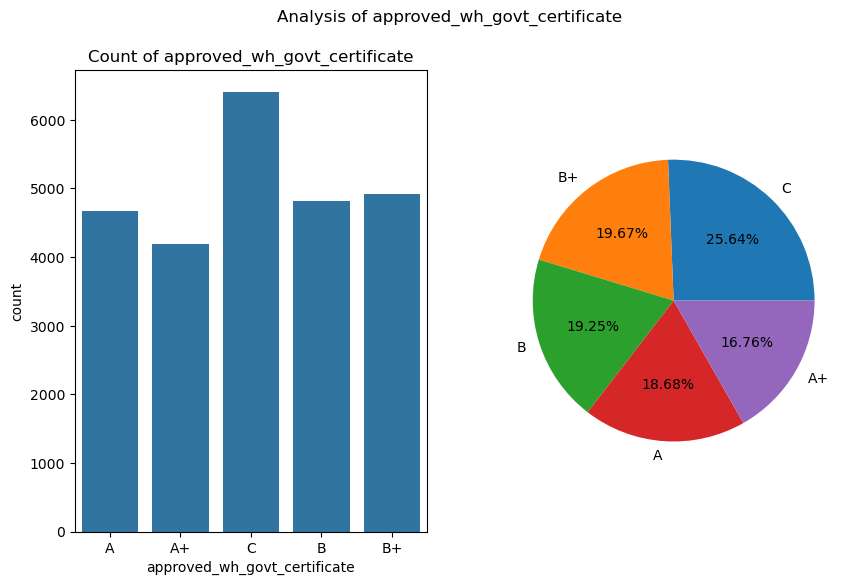

In [16]:
for i in cat:
    fig, ax= plt.subplots(1,2, figsize=(10,6))
    ax[0].set_title("Count of "+ col)
    val_counts= fmcg_data[col].value_counts()
    labels= list(val_counts.index)
    
    sns.countplot(x= fmcg_data[col], ax= ax[0])
    plt.pie(val_counts, labels= labels, autopct= "%0.2f%%")
    
    plt.suptitle("Analysis of " + col)
    plt.show()

In [17]:
numeric_cols

Index(['num_refill_req_l3m', 'transport_issue_l1y', 'Competitor_in_mkt',
       'retail_shop_num', 'distributor_num', 'dist_from_hub', 'workers_num',
       'storage_issue_reported_l3m', 'wh_breakdown_l3m', 'govt_check_l3m',
       'product_wg_ton'],
      dtype='object')

In [18]:
for col in numeric_cols:
    print(f'Name of the Column:{col}\n')
    print("Mean:", fmcg_data[col].mean() ,"    Median:",fmcg_data[col].median() , "   Mode:", fmcg_data[col].mode()[0])
    print("Range:", fmcg_data[col].max()- fmcg_data[col].min())
    q1= fmcg_data[col].quantile(0.25)
    q3= fmcg_data[col].quantile(0.75)
    iqr= q3-q1
    print("IQR:", iqr)
    print('Standard Deviation:', fmcg_data[col].std())
    lf= q1-1.5*iqr
    uf= q3+1.5*iqr
    condition_outlier= (fmcg_data[col]<lf)| (fmcg_data[col]>uf)
    print("lower fence:",lf)
    print("Upper fence:",uf)
    print("Total Outliers:", condition_outlier.sum())
    print("-------------------------------------------------------------")

Name of the Column:num_refill_req_l3m

Mean: 4.08904     Median: 4.0    Mode: 3
Range: 8
IQR: 4.0
Standard Deviation: 2.6066115275095574
lower fence: -4.0
Upper fence: 12.0
Total Outliers: 0
-------------------------------------------------------------
Name of the Column:transport_issue_l1y

Mean: 0.77368     Median: 0.0    Mode: 0
Range: 5
IQR: 1.0
Standard Deviation: 1.1994485419026377
lower fence: -1.5
Upper fence: 2.5
Total Outliers: 2943
-------------------------------------------------------------
Name of the Column:Competitor_in_mkt

Mean: 3.1042     Median: 3.0    Mode: 2
Range: 12
IQR: 2.0
Standard Deviation: 1.1416630395085952
lower fence: -1.0
Upper fence: 7.0
Total Outliers: 96
-------------------------------------------------------------
Name of the Column:retail_shop_num

Mean: 4958.8932     Median: 4859.0    Mode: 7280.5
Range: 4748.0
IQR: 1187.0
Standard Deviation: 969.4021407518122
lower fence: 2532.5
Upper fence: 7280.5
Total Outliers: 0
------------------------------

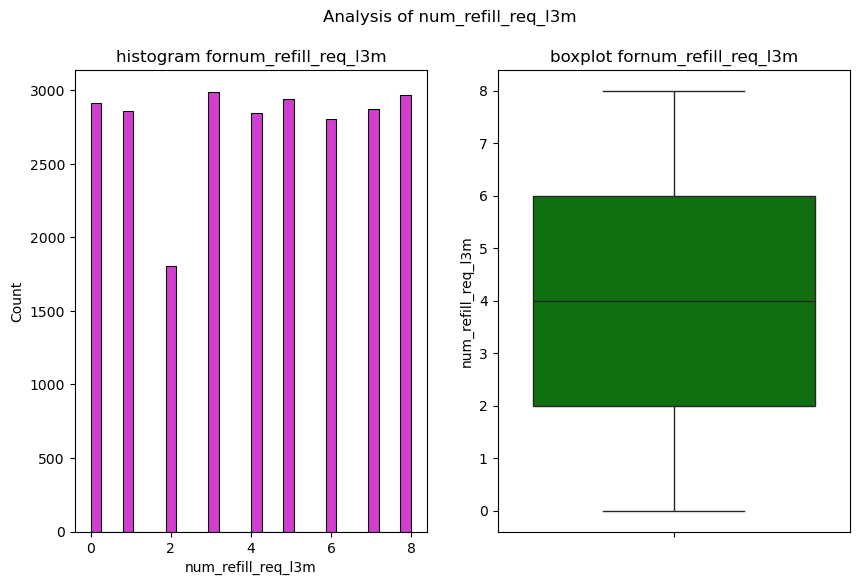

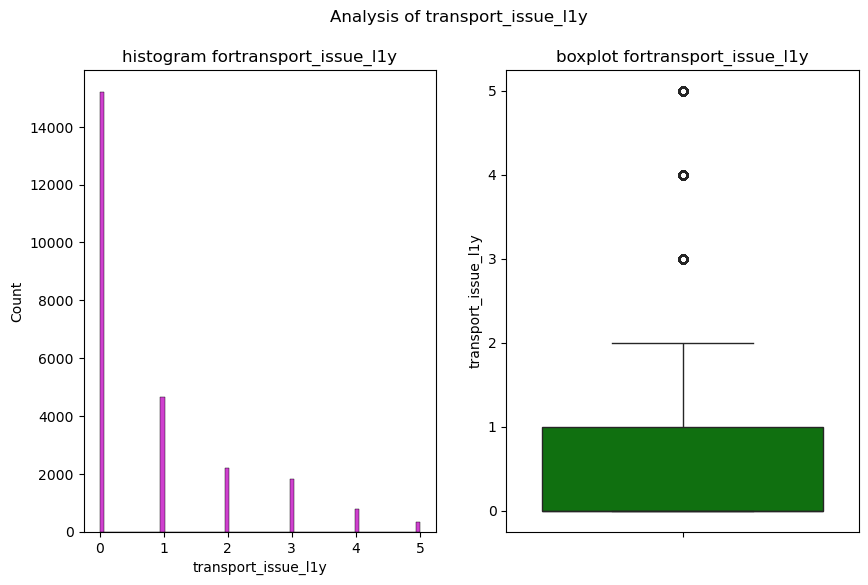

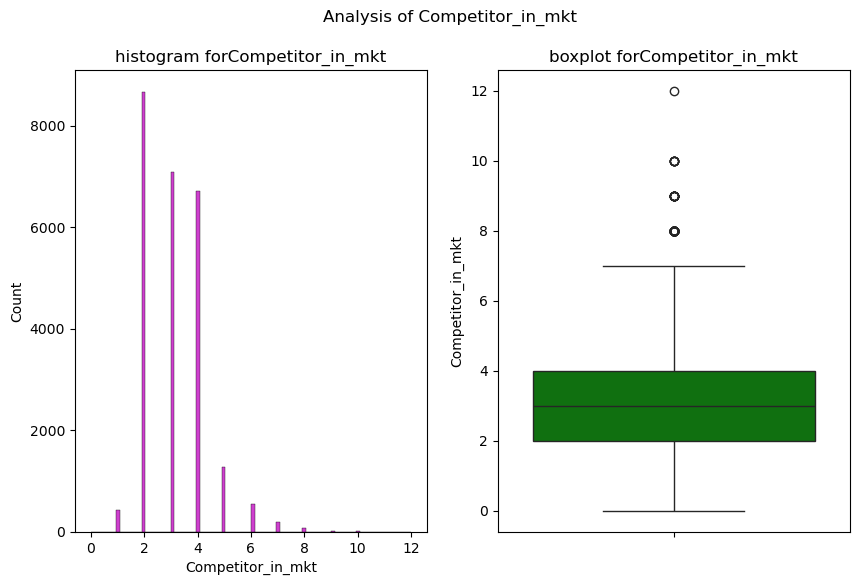

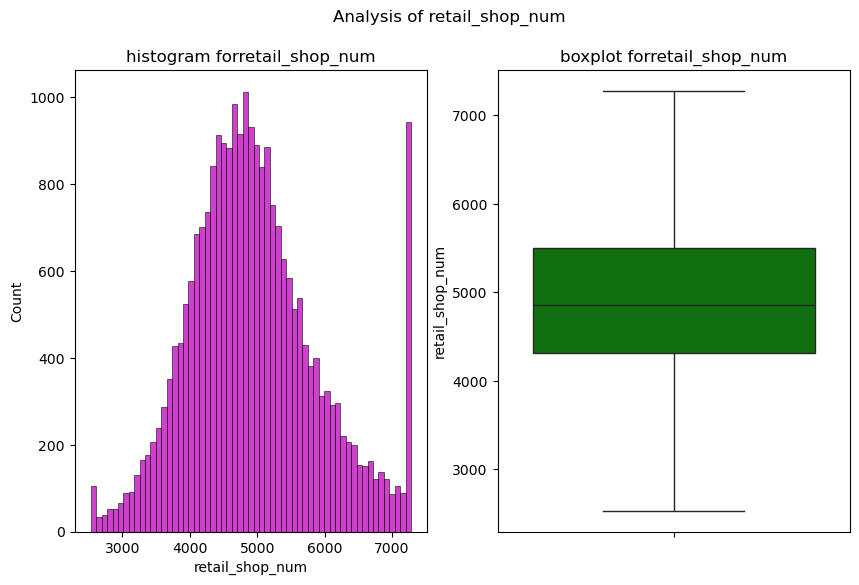

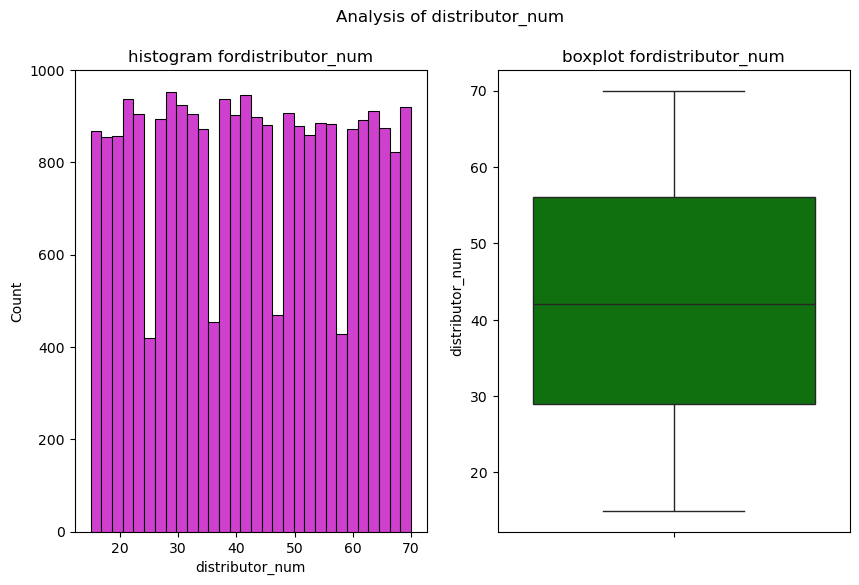

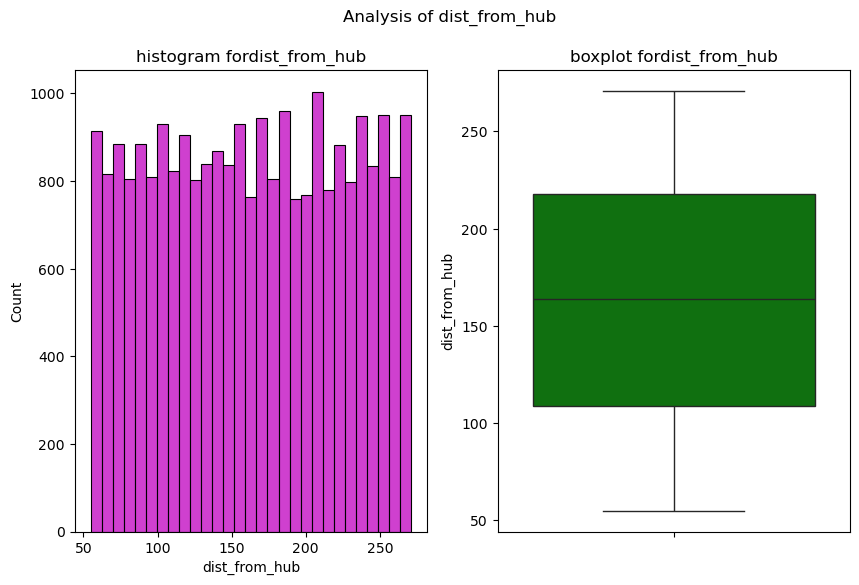

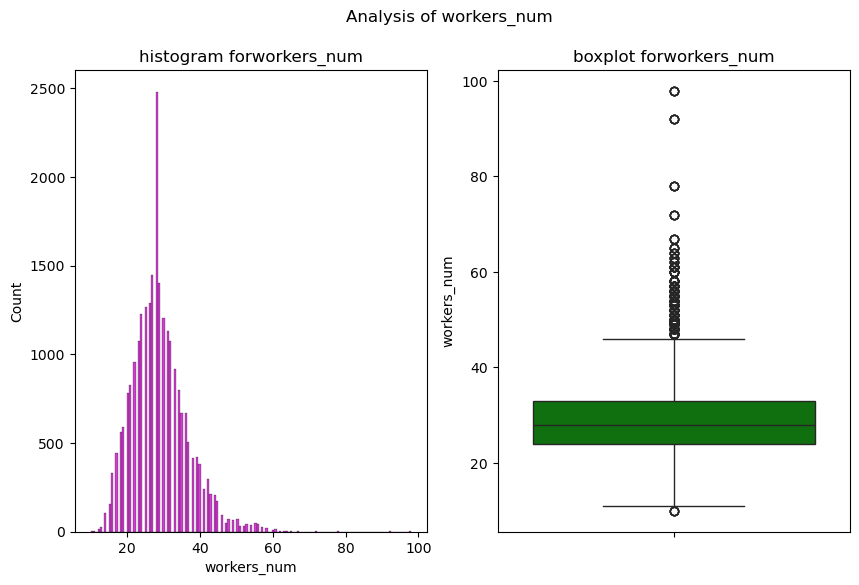

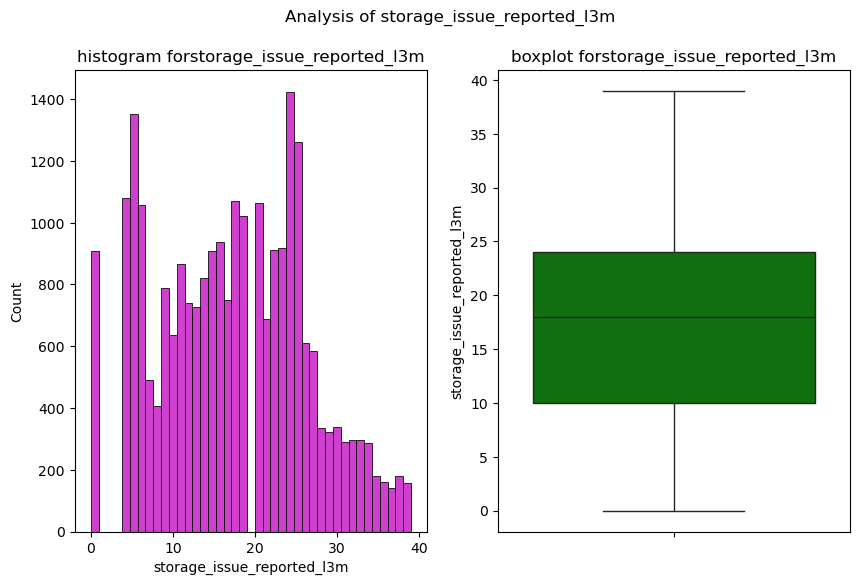

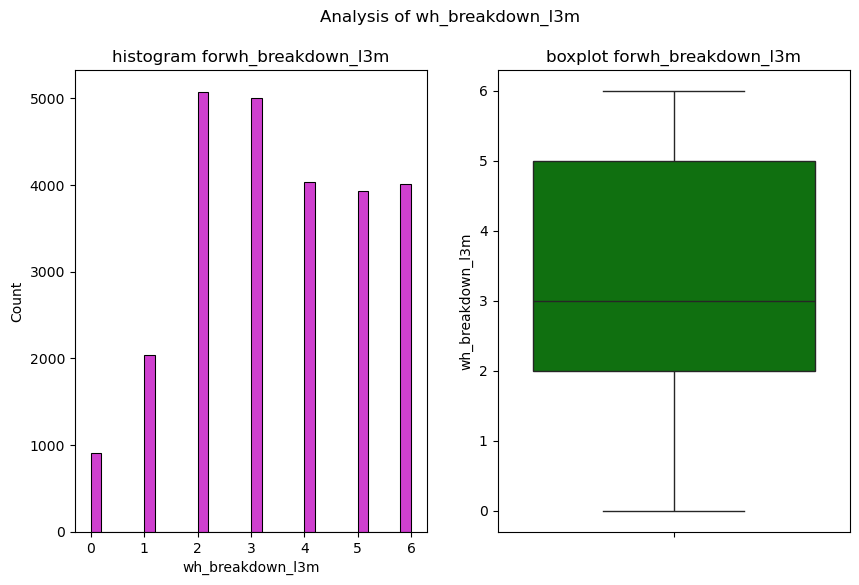

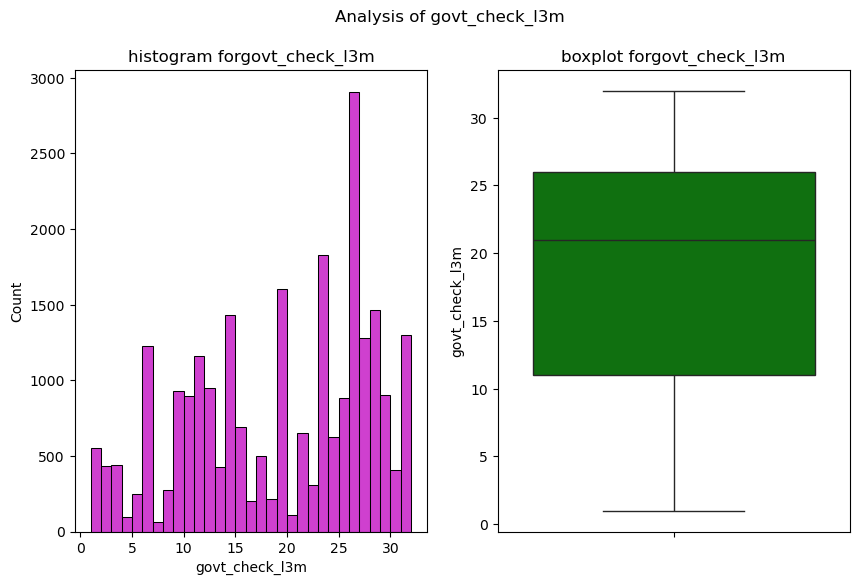

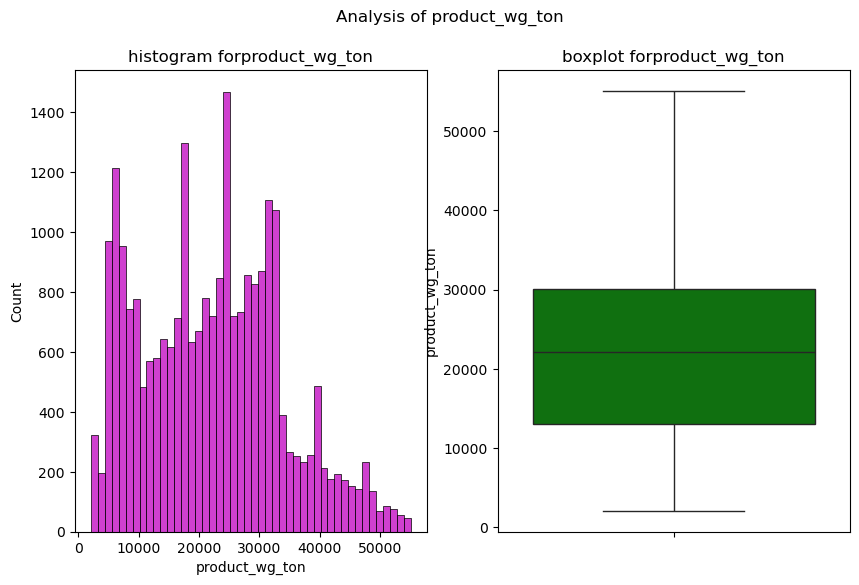

In [19]:
for col in numeric_cols:
    fig, ax= plt.subplots(1,2, figsize= (10,6))
    sns.histplot(fmcg_data[col], ax= ax[0], color= 'm')
    ax[0].set_title("histogram for"+col)
    sns.boxplot(fmcg_data[col], ax= ax[1], color= 'g')
    ax[1].set_title("boxplot for"+col)

    plt.suptitle("Analysis of "+col)
    plt.show

In [20]:
fmcg=sql.connect(host='localhost',user='root',password='kalai',database='fmcg_data')
fmcg

In [21]:
cursor=fmcg.cursor()

In [22]:
cursor.execute('select version()')

In [23]:
cursor.fetchone()

('8.0.41',)

In [24]:
query1 = '''
SELECT* FROM potential_stockout_risk;
'''
cursor.execute(query1)
potential_stockout_risk = cursor.fetchall()
columns1 = [desc[0] for desc in cursor.description]
potential_stockout_risk=pd.DataFrame(potential_stockout_risk,columns = columns1)
potential_stockout_risk.head()

,Ware_house_ID,WH_Manager_ID,Location_type,zone,WH_capacity_size,num_refill_req_l3m,Stockout_Risk,Recommendation
0,WH_100005,EID_50005,Rural,West,Small,8,Potential stockout risk,Consider reviewing inventory thresholds
1,WH_100006,EID_50006,Rural,West,Large,8,Potential stockout risk,Consider reviewing inventory thresholds
2,WH_100008,EID_50008,Rural,South,Small,8,Potential stockout risk,Consider reviewing inventory thresholds
3,WH_100014,EID_50014,Rural,West,Small,8,Potential stockout risk,Consider reviewing inventory thresholds
4,WH_100020,EID_50020,Rural,South,Mid,8,Potential stockout risk,Consider reviewing inventory thresholds


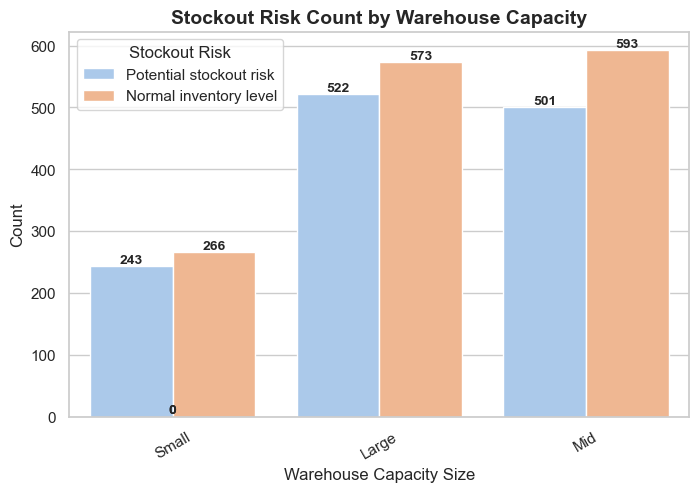

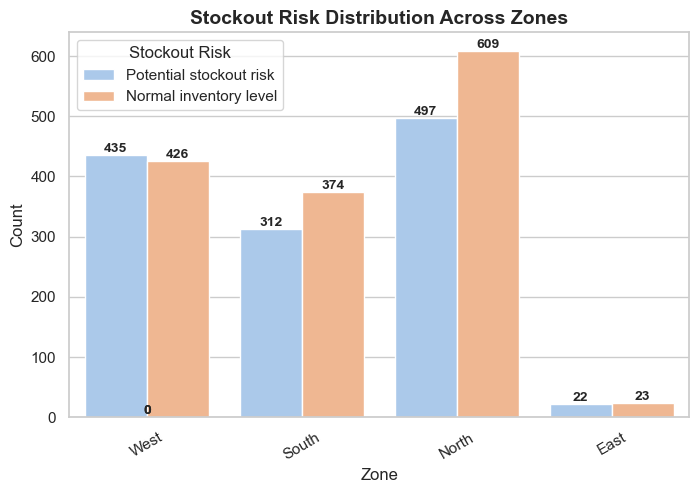

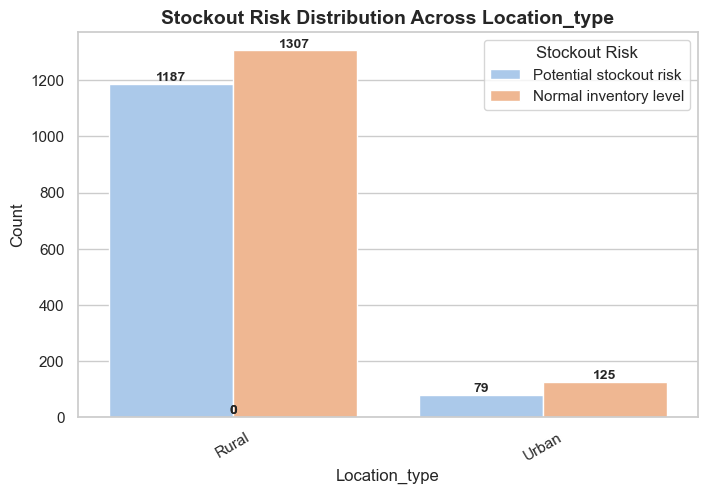

In [25]:
sns.set(style="whitegrid", palette="pastel")

def add_value_labels(ax):
    """Add value labels to bars in a seaborn plot"""
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')

# Figure 1: Count of Stockout Risk by Warehouse Capacity
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=potential_stockout_risk, x="WH_capacity_size", hue="Stockout_Risk")
plt.title("Stockout Risk Count by Warehouse Capacity", fontsize=14, fontweight='bold')
plt.xlabel("Warehouse Capacity Size", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Stockout Risk")
plt.xticks(rotation=30)
add_value_labels(ax)  # Add labels
plt.show()

# Figure 2: Distribution of Stockout Risk by Zone
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=potential_stockout_risk, x="zone", hue="Stockout_Risk")
plt.title("Stockout Risk Distribution Across Zones", fontsize=14, fontweight='bold')
plt.xlabel("Zone", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Stockout Risk")
plt.xticks(rotation=30)
add_value_labels(ax)  # Add labels
plt.show()

# Figure 3: Distribution of Stockout Risk by Location_type
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=potential_stockout_risk, x="Location_type", hue="Stockout_Risk")
plt.title("Stockout Risk Distribution Across Location_type", fontsize=14, fontweight='bold')
plt.xlabel("Location_type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Stockout Risk")
plt.xticks(rotation=30)
add_value_labels(ax)  # Add labels
plt.show()



In [26]:
query2 = '''
SELECT* FROM transport_issues;
'''
cursor.execute(query2)
results2 = cursor.fetchall()
columns2 = [desc[0] for desc in cursor.description]
results2=pd.DataFrame(results2,columns = columns2)
results2.head()

,Ware_house_ID,Location_type,zone,transport_issue_l1y,num_refill_req_l3m,Recommendation
0,WH_100154,Rural,North,5,5,Review and optimize transport routes
1,WH_100230,Rural,North,5,7,Review and optimize transport routes
2,WH_100312,Rural,West,5,8,Review and optimize transport routes
3,WH_100359,Rural,North,5,8,Review and optimize transport routes
4,WH_100529,Rural,North,5,8,Review and optimize transport routes


### Day 3 ML

In [28]:
fmcg_data.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,4651.0,...,1,1,91,29.0,13,0,A,5,15,17115
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,6217.0,...,0,1,210,31.0,4,0,A,3,17,5074
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,4306.0,...,0,0,161,37.0,17,0,A,6,22,23137
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,6000.0,...,0,0,103,21.0,17,1,A+,3,27,22115
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,4740.0,...,0,1,112,25.0,18,0,C,6,24,24071


In [29]:
ml_fmcg=fmcg_data.copy()
ml_fmcg.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,...,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,4651.0,...,1,1,91,29.0,13,0,A,5,15,17115
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,6217.0,...,0,1,210,31.0,4,0,A,3,17,5074
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,4306.0,...,0,0,161,37.0,17,0,A,6,22,23137
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,6000.0,...,0,0,103,21.0,17,1,A+,3,27,22115
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,4740.0,...,0,1,112,25.0,18,0,C,6,24,24071


In [30]:
col_r=['Ware_house_ID','WH_Manager_ID','wh_owner_type']
ml_fmcg.drop(col_r,axis=1,inplace=True)

In [31]:
ml_fmcg.head(5)

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,Urban,Small,West,Zone 6,3,1,2,4651.0,24,0,1,1,91,29.0,13,0,A,5,15,17115
1,Rural,Large,North,Zone 5,0,0,4,6217.0,47,0,0,1,210,31.0,4,0,A,3,17,5074
2,Rural,Mid,South,Zone 2,1,0,4,4306.0,64,0,0,0,161,37.0,17,0,A,6,22,23137
3,Rural,Mid,North,Zone 3,7,4,2,6000.0,50,0,0,0,103,21.0,17,1,A+,3,27,22115
4,Rural,Large,North,Zone 5,3,1,2,4740.0,42,1,0,1,112,25.0,18,0,C,6,24,24071


In [32]:
le = LabelEncoder()
for col in ml_fmcg.select_dtypes(include=['object','category']).columns:
    ml_fmcg[col] = le.fit_transform(ml_fmcg[col])

In [33]:
ml_fmcg

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,1,2,3,5,3,1,2,4651.0,24,0,1,1,91,29.0,13,0,0,5,15,17115
1,0,0,1,4,0,0,4,6217.0,47,0,0,1,210,31.0,4,0,0,3,17,5074
2,0,1,2,1,1,0,4,4306.0,64,0,0,0,161,37.0,17,0,0,6,22,23137
3,0,1,1,2,7,4,2,6000.0,50,0,0,0,103,21.0,17,1,1,3,27,22115
4,0,0,1,4,3,1,2,4740.0,42,1,0,1,112,25.0,18,0,4,6,24,24071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,2,1,0,3,0,4,5390.0,19,0,0,1,142,34.0,22,1,0,2,30,32093
24996,0,1,3,1,6,0,4,4490.0,57,0,0,1,130,28.0,10,0,2,4,18,12114
24997,1,0,2,4,7,0,2,5403.0,31,1,0,1,147,28.0,23,0,3,5,25,27080
24998,0,2,1,0,1,0,2,7280.5,25,0,0,1,60,25.0,18,0,0,6,30,25093


In [34]:
# Standardizing data together
cols= ml_fmcg.columns
scaler= StandardScaler()
scaled= scaler.fit_transform(ml_fmcg)
df_scaled= pd.DataFrame(scaled, columns=cols)
df_scaled.head()

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,3.352150,1.632547,1.276973,1.047901,-0.417807,0.188690,-0.967205,-0.317618,-1.146546,-0.329915,4.159520,0.722737,-1.156575,0.012051,-0.450876,-0.659770,-1.492968,0.898041,-0.441634,-0.429690
1,-0.298316,-1.056278,-0.986762,0.448470,-1.568750,-0.645043,0.784661,1.297843,0.285226,-0.329915,-0.240412,0.722737,0.740827,0.271215,-1.433309,-0.659770,-1.492968,-0.285180,-0.209944,-1.467034
2,-0.298316,0.288135,0.145105,-1.349822,-1.185102,-0.645043,0.784661,-0.673514,1.343493,-0.329915,-0.240412,-1.383630,-0.040456,1.048707,-0.014239,-0.659770,-1.492968,1.489652,0.369282,0.089112
3,-0.298316,0.288135,-0.986762,-0.750391,1.116783,2.689890,-0.967205,1.073989,0.471979,-0.329915,-0.240412,-1.383630,-0.965240,-1.024605,-0.014239,1.515679,-0.804355,-0.285180,0.948508,0.001065
4,-0.298316,-1.056278,-0.986762,0.448470,-0.417807,0.188690,-0.967205,-0.225807,-0.026028,3.031081,-0.240412,0.722737,-0.821739,-0.506277,0.094921,-0.659770,1.261484,1.489652,0.600972,0.169577


In [35]:
# Extract the last row index
last_row= len(df_scaled)-1

# Extract the last row using iloc and store in a new DataFrame
validation= df_scaled.iloc[last_row]
validation
# Reshape the extracted Series into a DataFrame (optional)
new_data_df= validation.to_frame().transpose()

In [36]:
new_data_df

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
24999,-0.298316,0.288135,1.276973,-0.150961,1.50043,1.022424,0.784661,0.727377,-1.333299,-0.329915,4.15952,0.722737,1.203218,1.307871,-1.433309,-0.65977,0.572871,-0.876791,-0.905015,-1.468413


In [37]:
# Retrieve original data by excluding new data
df_scaled= df_scaled.iloc[:-1]
df_scaled

,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,3.352150,1.632547,1.276973,1.047901,-0.417807,0.188690,-0.967205,-0.317618,-1.146546,-0.329915,4.159520,0.722737,-1.156575,0.012051,-0.450876,-0.659770,-1.492968,0.898041,-0.441634,-0.429690
1,-0.298316,-1.056278,-0.986762,0.448470,-1.568750,-0.645043,0.784661,1.297843,0.285226,-0.329915,-0.240412,0.722737,0.740827,0.271215,-1.433309,-0.659770,-1.492968,-0.285180,-0.209944,-1.467034
2,-0.298316,0.288135,0.145105,-1.349822,-1.185102,-0.645043,0.784661,-0.673514,1.343493,-0.329915,-0.240412,-1.383630,-0.040456,1.048707,-0.014239,-0.659770,-1.492968,1.489652,0.369282,0.089112
3,-0.298316,0.288135,-0.986762,-0.750391,1.116783,2.689890,-0.967205,1.073989,0.471979,-0.329915,-0.240412,-1.383630,-0.965240,-1.024605,-0.014239,1.515679,-0.804355,-0.285180,0.948508,0.001065
4,-0.298316,-1.056278,-0.986762,0.448470,-0.417807,0.188690,-0.967205,-0.225807,-0.026028,3.031081,-0.240412,0.722737,-0.821739,-0.506277,0.094921,-0.659770,1.261484,1.489652,0.600972,0.169577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,-0.298316,0.288135,-0.986762,-0.150961,1.116783,-0.645043,-0.091272,0.292049,-0.088279,-0.329915,-0.240412,-1.383630,-1.475466,-0.506277,-0.887513,-0.659770,-0.115742,-1.468401,0.832663,-0.949353
24995,-0.298316,1.632547,-0.986762,-1.949253,-0.417807,-0.645043,0.784661,0.444723,-1.457801,-0.329915,-0.240412,0.722737,-0.343403,0.659961,0.531558,1.515679,-1.492968,-0.876791,1.296044,0.860680
24996,-0.298316,0.288135,1.276973,-1.349822,0.733135,-0.645043,0.784661,-0.483703,0.907736,-0.329915,-0.240412,0.722737,-0.534737,-0.117531,-0.778354,-0.659770,-0.115742,0.306431,-0.094099,-0.860531
24997,3.352150,-1.056278,0.145105,0.448470,1.116783,-0.645043,-0.967205,0.458134,-0.710789,3.031081,-0.240412,0.722737,-0.263680,-0.117531,0.640717,-0.659770,0.572871,0.898041,0.716818,0.428805


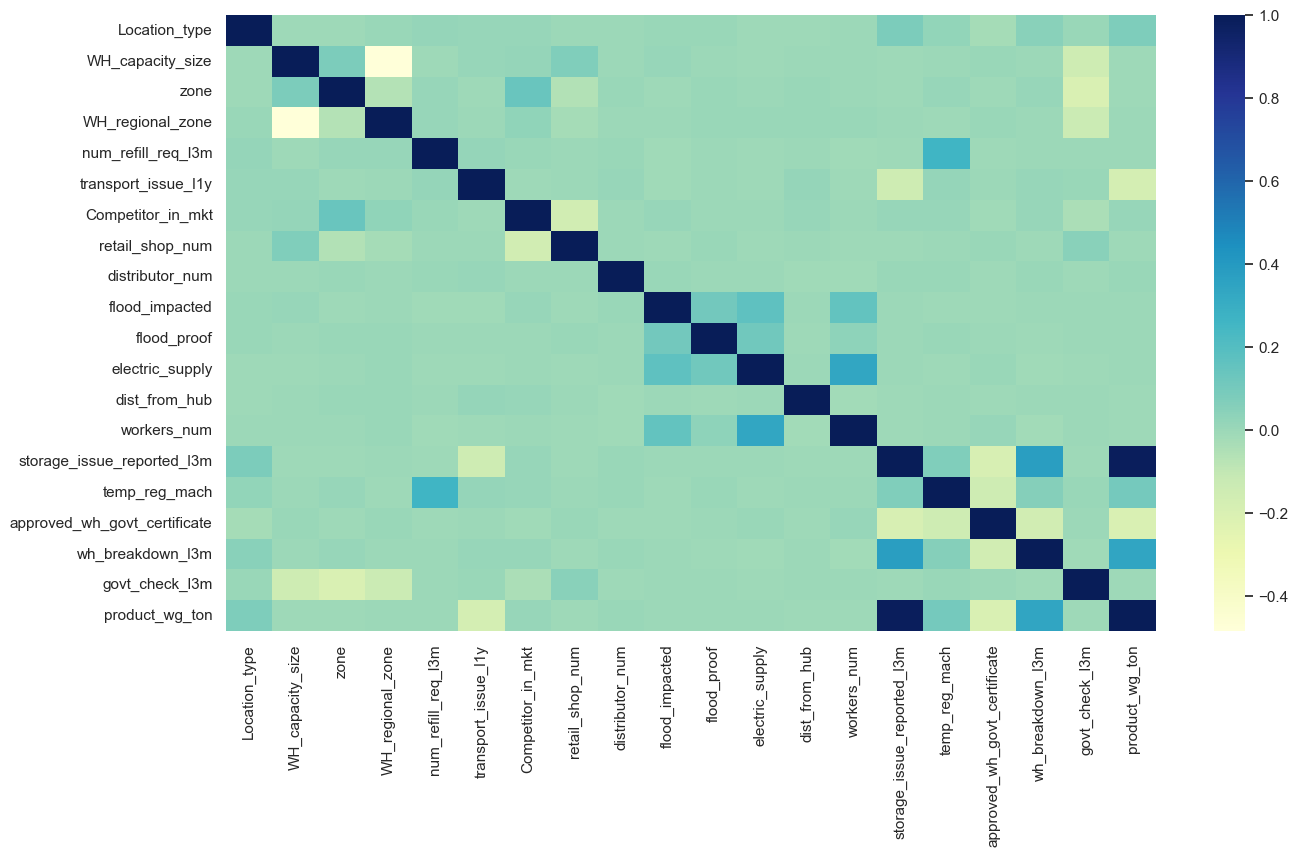

In [38]:
# Plotting heatmap
fig, ax= plt.subplots(1,1, figsize=(15,8))
ax= sns.heatmap(df_scaled.corr(),annot= False, cmap="YlGnBu")

In [39]:
df_scaled.corr()['product_wg_ton']

Location_type                   0.074553
WH_capacity_size               -0.004408
zone                           -0.006596
WH_regional_zone                0.000554
num_refill_req_l3m              0.001503
transport_issue_l1y            -0.173943
Competitor_in_mkt               0.008931
retail_shop_num                -0.007224
distributor_num                 0.004921
flood_impacted                 -0.002318
flood_proof                    -0.000197
electric_supply                -0.002117
dist_from_hub                  -0.004947
workers_num                    -0.007996
storage_issue_reported_l3m      0.986776
temp_reg_mach                   0.101604
approved_wh_govt_certificate   -0.200428
wh_breakdown_l3m                0.342654
govt_check_l3m                 -0.008553
product_wg_ton                  1.000000
Name: product_wg_ton, dtype: float64

In [40]:
features = df_scaled.drop(['product_wg_ton'], axis=1)  # Include all other features as predictors
target = df_scaled['product_wg_ton']

vif_data = pd.DataFrame()
vif_data['Feature'] = features.columns
vif_data['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

# Display the VIF values
print(vif_data.sort_values(by='VIF', ascending=False))

                         Feature       VIF
1               WH_capacity_size  1.402665
3               WH_regional_zone  1.397114
14    storage_issue_reported_l3m  1.228890
17              wh_breakdown_l3m  1.184991
11               electric_supply  1.152751
13                   workers_num  1.140411
18                govt_check_l3m  1.130208
15                 temp_reg_mach  1.101906
4             num_refill_req_l3m  1.075611
2                           zone  1.070040
16  approved_wh_govt_certificate  1.069190
9                 flood_impacted  1.050188
6              Competitor_in_mkt  1.049612
7                retail_shop_num  1.038538
5            transport_issue_l1y  1.029242
10                   flood_proof  1.022099
0                  Location_type  1.007736
12                 dist_from_hub  1.001000
8                distributor_num  1.000712


In [41]:
x = df_scaled.drop(['product_wg_ton'], axis=1)  # Include all other features as predictors
y = df_scaled['product_wg_ton']
x.shape
y.shape
x_train, x_test, y_train, y_test =train_test_split(x,y, test_size= 0.3, random_state= 100)
print(x_train.shape)
print(x_test.shape)
model= LinearRegression() 
model.fit(x_train, y_train) 
y_pred=model.predict(x_test) 
model.score(x_train, y_train)
# Print Intercept and Slope

# Calculating MSE, MAE, RMSE, R-Square
mse= mean_squared_error(y_test,y_pred)
mae= mean_absolute_error(y_test, y_pred)
rmse= mse**0.5
print('model.intercept',model.intercept_)
print("________________________________________________________________________________")
print('model.coef_',model.coef_)
print("________________________________________________________________________________")
print("Mean Squared Error:", mse)

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print('r2_score:',r2_score(y_test,y_pred))

(17499, 19)
(7500, 19)
model.intercept -0.0001823007260395349
________________________________________________________________________________
model.coef_ [-2.91351253e-03  1.22261420e-03 -1.28333510e-03 -1.81066009e-04
 -5.61668055e-04 -3.16507815e-02 -1.25522368e-03 -4.36592659e-04
  1.88517717e-03  1.96921435e-04  1.77516590e-03  6.14055425e-04
  5.04217223e-04 -8.77658826e-04  9.91239072e-01  3.56757703e-02
 -1.26751205e-02 -3.48398863e-02 -2.85201704e-03]
________________________________________________________________________________
Mean Squared Error: 0.02238111103780101
Mean Absolute Error: 0.11034605284605677
Root Mean Squared Error: 0.1496031785685084
r2_score: 0.9775418396442541


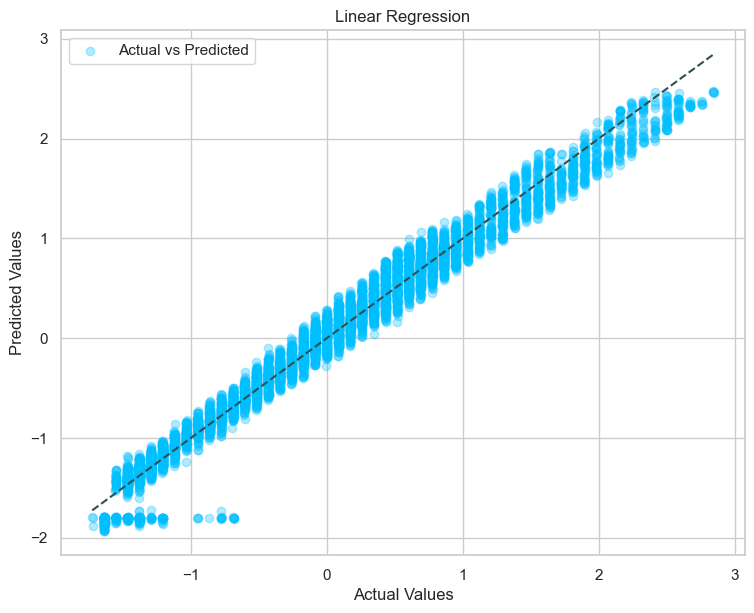

In [42]:
plt.figure(figsize=(30, 15))

# Linear Regression Plot
ax1 = plt.subplot2grid((2, 3), (0, 0))
plt.scatter(y_test, y_pred, color='deepskyblue', alpha=0.3, label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='darkslategray')
plt.title('Linear Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.show()
